# Output Analysis

This is an attempt to analyse the output from the [Exchange Simulator](https://github.com/hackinghat/exchange-simulator-java).  The purpose of this analysis is to visually verify that the simulator is producing plausible prices.

Running the simulator should produce outputs in the folder `../out` and this analysis simply shows some visualisations of the data in those folders.


In [11]:
import os, re, time
import matplotlib.pyplot as plt, pandas as pd, numpy as np

from matplotlib import dates
hr = dates.HourLocator(interval=1)
mn = dates.MinuteLocator(interval=15)
dfmt = dates.DateFormatter('%H:%M')

%matplotlib inline

def read_timeseries(sample_file_name):
    df = pd.read_csv(sample_file_name, thousands=',')
    df["T"] = pd.to_datetime(df["T"])
    df.set_index("T", inplace = True)
    return df

def adjust_sample(sample_file_name):
    sample = read_timeseries(sample_file_name)
    cont_state = (sample.State == "CONTINUOUS") & (sample["Day#"] == 1)                                                
    #cont_state = sample.State == "CONTINUOUS"
    sample = sample[cont_state]
    sample.drop("State", inplace=True, axis=1)
    return cont_state, sample.astype(float)

def count_auctions():
    dc = cont_3.astype(int).diff()
    dc[(dc != 0.0) & (~dc.isna())]
    
def latest_stats(path, stats_type, n=1):
    simulator_output_re = r'([A-Z\-]+)\.([0-9\-]+)\.csv'
    simulator_files = [(x, re.match(simulator_output_re,x)) for x in os.listdir(path)]
    result = []
    for file, match in simulator_files:
        if match and match[1] == stats_type:
            try:
                result.append((time.mktime(time.strptime(match[2][:13], '%Y%m%d-%H%M')), file))
            except ValueError:
                pass
    if len(result):
        return [os.path.join(path, x[1]) for x in sorted(result, key=lambda x: x[0])[-n:]]
    else: 
        raise ValueError('No matching stats files \'%s\' found in \'%s\'' % (stats_type, path))


latest_samples = latest_stats('../out', 'SAMPLE', 1)    
sample_files = [adjust_sample(f) for f in latest_samples]


## River plot of spread

Every time step has two prices, the buy price and the sell price.  The difference between them is the spread.  
For our exchange to be performing as intended will mean that the exchange is giving fair outputs and that we don't see
wide variations in spread.

<module 'matplotlib.pyplot' from '/usr/lib64/python3.10/site-packages/matplotlib/pyplot.py'>

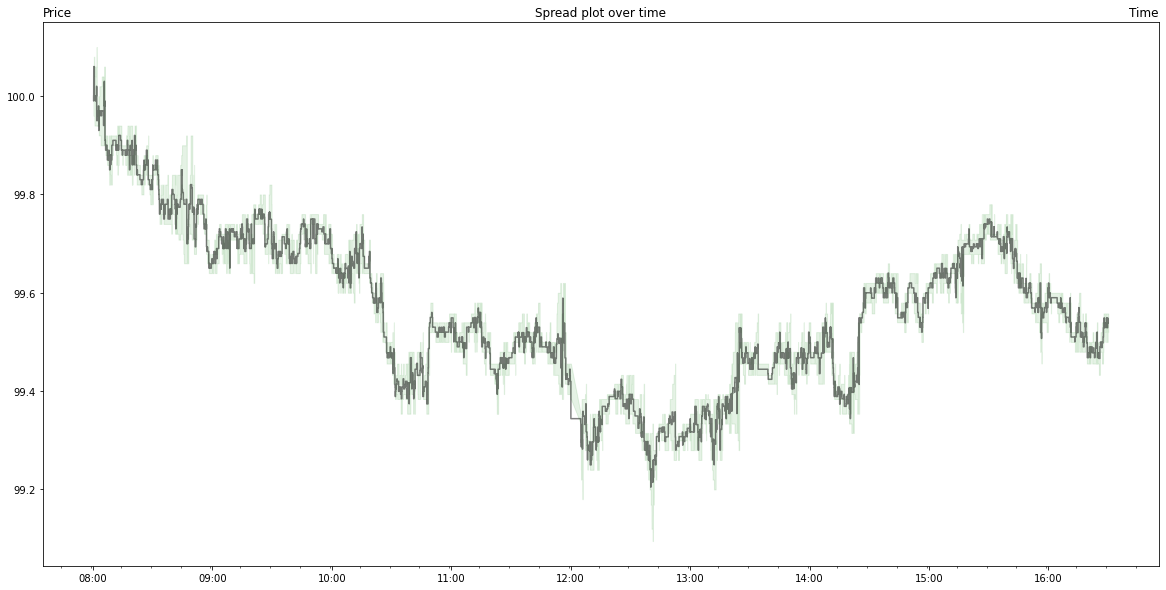

In [12]:
sample_tick = sample_files[0][1]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.xaxis.set_major_locator(hr)
ax.xaxis.set_major_formatter(dfmt)
ax.xaxis.set_minor_locator(mn)
ax.set_title('Price', loc='left')
ax.set_title('Time', loc='right')
plt.step(sample_tick.index, sample_tick.Mid, alpha=0.5, color='black')
plt.fill_between(sample_tick.index, sample_tick.Bid, sample_tick.Offer, alpha=0.1, color='green')
plt.title('Spread plot over time')
plt

## Plausible spread

We now take a look at the stability of the spread.  We're trying to see if the range of possible spreads (seen in the chart above as pale green bars below the mid) doesn't have too many extreme values and most values are clustered  just above zero.

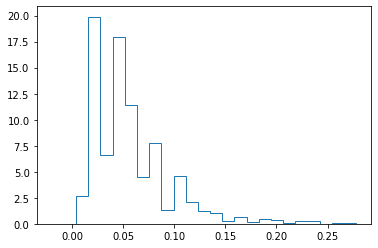

In [6]:
plt.hist(sample_tick.Spd, density=True, histtype='step', bins=25);

## Agent leader board

From all our agents who made and lost the most money.  What is their P&L?  We probably shouldn't expect anyone to lose their shirt or for anyone to become wildly rich!

In [11]:
import os, re, time

def agent_name(cash_col, share_col):
    result = ''
    for (cc, sc) in zip(iter(cash_col), iter(share_col)):
        if cc == sc:
            result += cc
        else:
            break
    return result.strip()

def value_holdings(agents, valuation_price):
    df = pd.DataFrame()
    df["T"] = agents.index
    df.set_index("T", inplace=True)
    first_day = agents["Day#"] == 1
    agents.drop("Day#", axis=1, inplace=True)
    it = iter(agents.columns)
    agent_names = list(zip(it, it))
    for (cash_col, shares_col) in agent_names:
        #print(cash_col)
        df[agent_name(cash_col, shares_col)] = agents[cash_col] + agents[shares_col] * valuation_price
    # Filter out days after day 1
    return df[first_day]
        
agents = read_timeseries(latest_stats('../out', 'AGENT')[0])
agent_value = value_holdings(agents, 100.0)


ZERO #14 valuation = 199226.90, ZERO #2 valuation = 200636.10


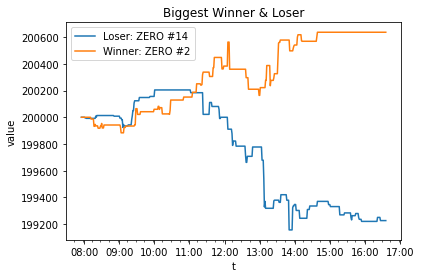

In [12]:
last_valuation = agent_value.iloc[-1,:]
min_idx = last_valuation[last_valuation != 0.0].idxmin()
max_idx = last_valuation[last_valuation != 0.0].idxmax()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_major_locator(hr)
ax.xaxis.set_major_formatter(dfmt)
ax.xaxis.set_minor_locator(mn)
plt.xlabel('t')
plt.ylabel('value')
plt.plot(agent_value.loc[:,min_idx])
plt.plot(agent_value.loc[:,max_idx])
plt.legend(['Loser: %s' % str(min_idx), 'Winner: %s' % str(max_idx)])
plt.title('Biggest Winner & Loser')
print("%s valuation = %.2f, %s valuation = %.2f" % (min_idx, last_valuation[min_idx], max_idx, last_valuation[max_idx]))